In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, mean_absolute_error, mean_squared_error, precision_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor

import datetime
from datetime import datetime, timedelta

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv(DATA_DIR+'/train.csv')
test = pd.read_csv(DATA_DIR+'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [3]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [5]:
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [6]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [7]:
#Объединяем train и test в один датасет
train['train'] = 1 # тренировочные данные
test['train'] = 0  # тестовые данные
df = pd.concat([train, test], ignore_index=True)
df.info

<bound method DataFrame.info of         client_id   app_date education sex  age car car_type  decline_app_cnt  \
0           25905  01FEB2014       SCH   M   62   Y        Y                0   
1           63161  12MAR2014       SCH   F   59   N        N                0   
2           25887  01FEB2014       SCH   M   25   Y        N                2   
3           16222  23JAN2014       SCH   F   53   N        N                0   
4          101655  18APR2014       GRD   M   48   N        N                0   
...           ...        ...       ...  ..  ...  ..      ...              ...   
110143      83775  31MAR2014       SCH   F   37   N        N                1   
110144     106254  25APR2014       GRD   F   64   Y        Y                0   
110145      81852  30MAR2014       GRD   M   31   N        N                2   
110146       1971  07JAN2014       UGR   F   27   N        N                1   
110147      69044  17MAR2014       SCH   M   38   N        N                0

In [8]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


client_id                 идентификатор клиента

app_date                  дата добавления

education                 уровень образования

sex                       пол заемщика

age                       возраст заемщика

car                       флаг наличия автомобиля

car_type                  флаг автомобиля_иномарки

decline_app_cnt           количество отказанных прошлых заявок

good_work                 флаг наличия хорошей работы

score_bki                 оценка кредитной истории

bki_reguest_cnt           количество запросов БКИ

region_rating             региональный рейтинг

home_address              категоризатор домашнего адреса

work_address              категоризатор рабочего адреса

income                    доход заемщика

sna                       связь заемщика с клиентами банка

first_time                степень давности становления

foreign_pasport           наличие загранпаспорта

default                   наличие дефолта

In [9]:
#посмотрим количество пропусков
df.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
dtype: int64

In [10]:
# количество пропусков по столбцам в %, пропусков не много.
for col in df.columns:
    pct_missing = df[col].isna().mean()
    print(f'{col} - {pct_missing :.1%}')

client_id - 0.0%
app_date - 0.0%
education - 0.4%
sex - 0.0%
age - 0.0%
car - 0.0%
car_type - 0.0%
decline_app_cnt - 0.0%
good_work - 0.0%
score_bki - 0.0%
bki_request_cnt - 0.0%
region_rating - 0.0%
home_address - 0.0%
work_address - 0.0%
income - 0.0%
sna - 0.0%
first_time - 0.0%
foreign_passport - 0.0%
default - 33.0%
train - 0.0%


<bound method IndexOpsMixin.value_counts of 0         SCH
1         SCH
2         SCH
3         SCH
4         GRD
         ... 
110143    SCH
110144    GRD
110145    GRD
110146    UGR
110147    SCH
Name: education, Length: 110148, dtype: object>

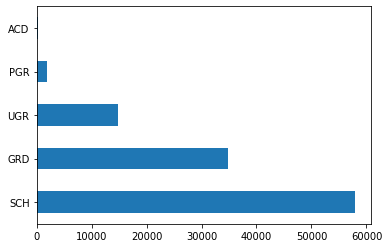

In [11]:
# Посмотрим на распределение переменной education
df['education'].value_counts().plot.barh()
df.education.value_counts

In [12]:
# заменим пропуски модой
df.education.fillna(df.education.mode()[0], inplace = True)

In [13]:
# проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [14]:
# Перекодируем значения education в числа
label_encoder = LabelEncoder()

df['education'] = label_encoder.fit_transform(df['education'])
print(dict(enumerate(label_encoder.classes_)))
df.head()

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,3,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,3,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,3,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,3,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,1,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


In [15]:
#Переведем дату в удобный вид
df['ap_date'] = df['app_date'].apply(pd.Timestamp)

In [16]:
#Удалим старую дату
df.drop(['app_date'], inplace = True, axis = 1)

In [17]:
#Добавим признаки года, месяца, дня.
df['year'] = df.ap_date.dt.year
df['month'] = df.ap_date.dt.month
df['day'] = df.ap_date.dt.day

In [18]:
# Количество дней с начала наблюденийЖ
df['count_days'] = (df.ap_date - df.ap_date.min()).dt.days

In [19]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,sna,first_time,foreign_passport,default,train,ap_date,year,month,day,count_days
0,25905,3,M,62,Y,Y,0,0,-2.008753,1,...,4,1,N,0.0,1,2014-02-01,2014,2,1,31
1,63161,3,F,59,N,N,0,0,-1.532276,3,...,4,1,N,0.0,1,2014-03-12,2014,3,12,70
2,25887,3,M,25,Y,N,2,0,-1.408142,1,...,1,4,Y,0.0,1,2014-02-01,2014,2,1,31
3,16222,3,F,53,N,N,0,0,-2.057471,2,...,1,3,N,0.0,1,2014-01-23,2014,1,23,22
4,101655,1,M,48,N,N,0,1,-1.244723,1,...,1,4,Y,0.0,1,2014-04-18,2014,4,18,107


In [20]:
# Посмотрим на год
df.year.value_counts()

2014    110148
Name: year, dtype: int64

In [21]:
# Год везде один, удалим колонку
df.drop(['year'], inplace = True, axis = 1)

In [22]:
# Посмотрим что с месяцами
df.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: month, dtype: int64

In [23]:
#Дата тоже больше не нужна
df.drop(['ap_date'], inplace = True, axis = 1)

In [24]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,train,month,day,count_days
0,25905,3,M,62,Y,Y,0,0,-2.008753,1,...,2,18000,4,1,N,0.0,1,2,1,31
1,63161,3,F,59,N,N,0,0,-1.532276,3,...,3,19000,4,1,N,0.0,1,3,12,70
2,25887,3,M,25,Y,N,2,0,-1.408142,1,...,2,30000,1,4,Y,0.0,1,2,1,31
3,16222,3,F,53,N,N,0,0,-2.057471,2,...,3,10000,1,3,N,0.0,1,1,23,22
4,101655,1,M,48,N,N,0,1,-1.244723,1,...,3,30000,1,4,Y,0.0,1,4,18,107


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int64  
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

<AxesSubplot:>

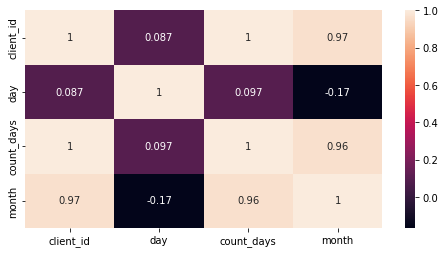

In [26]:
# Посмотрим корреляцию новых признаков и client_id
dif_cols = ['client_id', 'day', 'count_days', 'month']
plt.figure(figsize=(8,4))
sns.heatmap(df[dif_cols].corr(), annot = True)

In [27]:
# исключим месяцы и count_days
df.drop(['month'], inplace = True, axis = 1)
df.drop(['count_days'], inplace = True, axis = 1)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int64  
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

In [29]:
# Разделим признаки на числовые. бинарные и категориальные
num_cols = ['age', 'day', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']

In [30]:
#Применим LabelEncoder к бинарным переменным
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [31]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,day
0,25905,3,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0.0,1,1
1,63161,3,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0.0,1,12
2,25887,3,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0.0,1,1
3,16222,3,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0.0,1,23
4,101655,1,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0.0,1,18


In [32]:
# Разделим датасет на трейн и тест
train_n = df.query('train == 1').drop(['train'], axis = 1)
test_n = df.query('train ==0').drop(['train'], axis = 1)


In [33]:
#наивная модель
X = train_n.drop(['default'], axis = 1).values
Y = train_n['default'].values
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)


In [34]:
model_n = LogisticRegression(max_iter = 100)
model_n.fit(X_train, y_train)
y_pred = model_n.predict(X_test)

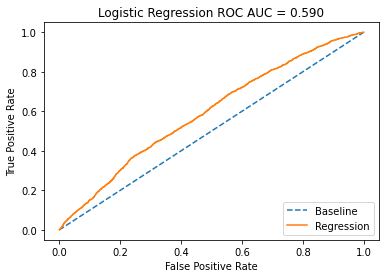

In [35]:
probs = model_n.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label = 'Baseline', linestyle = '--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()


In [36]:
# Оценка качества
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 3)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 3)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 3)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 3)))

accuracy_score: 0.876
f1_score: 0.0
recall_score: 0.0
MSE: 0.124


<AxesSubplot:>

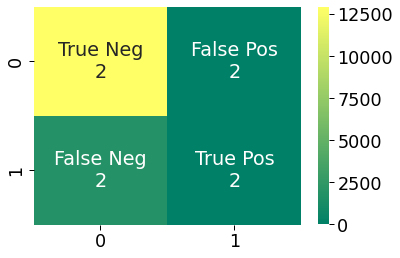

In [37]:
# Визуализация confusion matrix
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{2}' for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='summer')

0.0    64427
1.0     9372
Name: default, dtype: int64

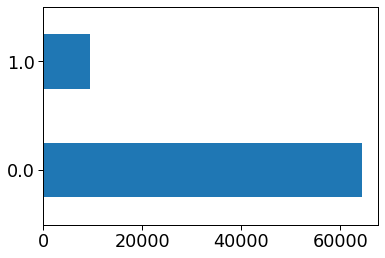

In [38]:
# Посмотрим на распределение целевой переменной
df['default'].value_counts().plot.barh()
df.default.value_counts()

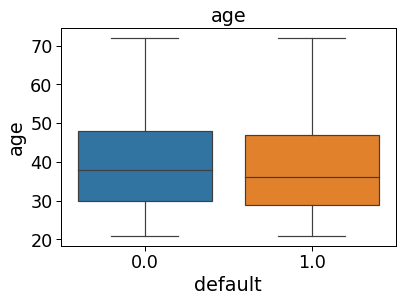

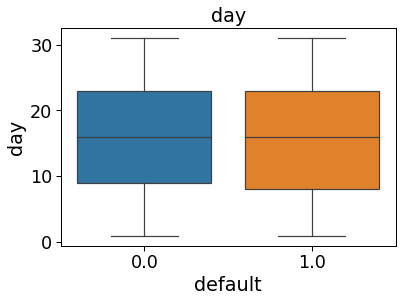

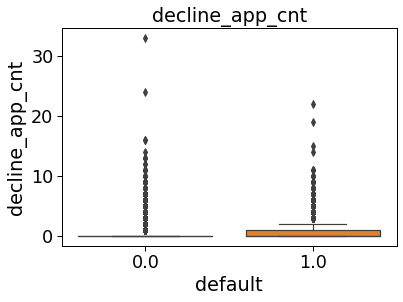

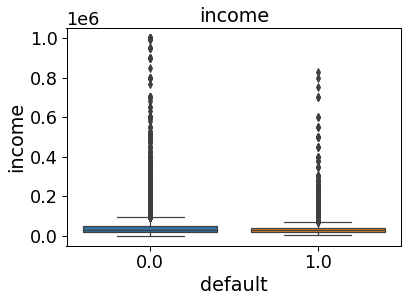

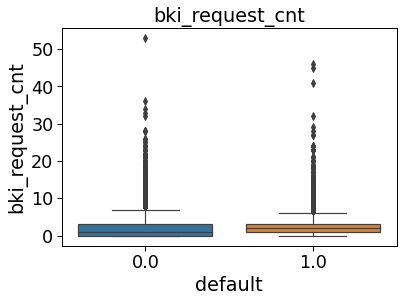

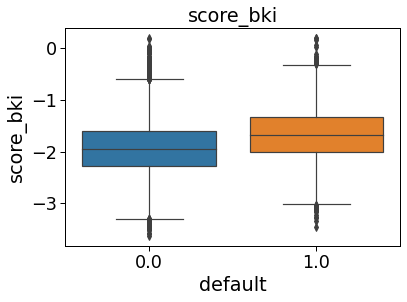

In [39]:
# Построим и рассмотрим боксплоты
data = df.copy()
for i in num_cols:
    plt.figure()
    sns.boxplot(x='default', y = i, data = data)
    plt.title(i)


In [40]:
# День можно исключить из признаков и из списка числовых признаков
df.drop(['day'], axis=1, inplace=True)
num_cols.remove('day')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int64  
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  int64  
 4   car               110148 non-null  int64  
 5   car_type          110148 non-null  int64  
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

<AxesSubplot:>

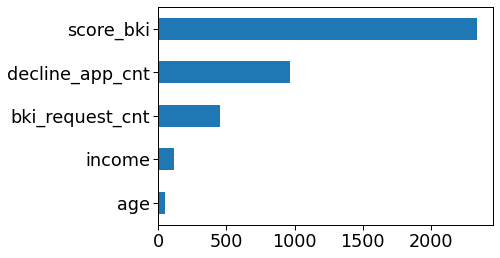

In [42]:
# Посмотрим как числовые признаки влияют на целевую переменную
num_df = df[df['train'] == 1]
imp_num = Series(f_classif(num_df[num_cols], num_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


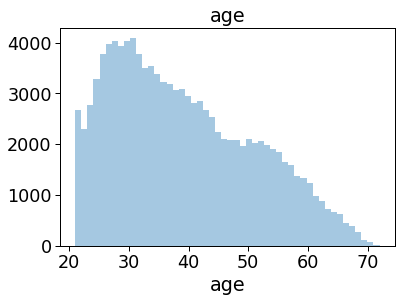

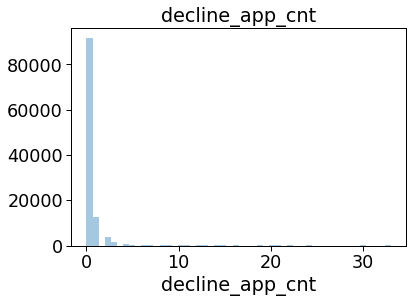

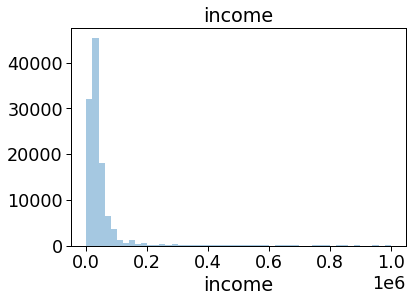

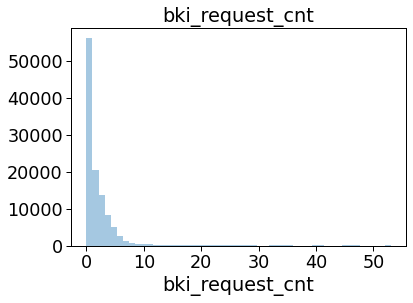

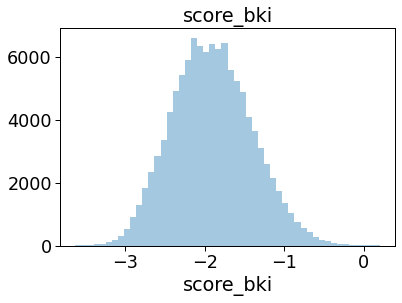

In [43]:
# Построим график распределения числовых переменных
for i in num_cols:
    plt.figure()
    
    sns.distplot(df[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

In [44]:
num_cols

['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']

In [45]:
#score_bki имеет нормальное распределение

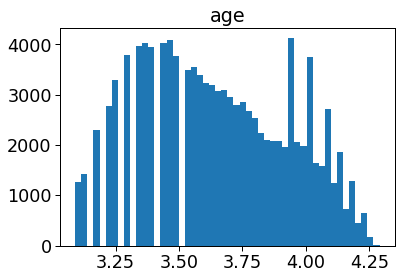

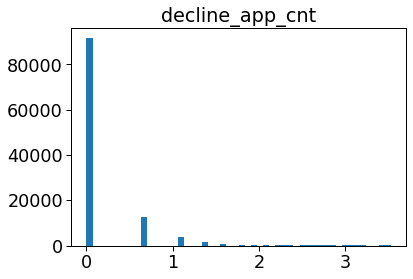

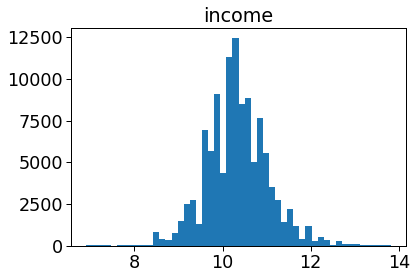

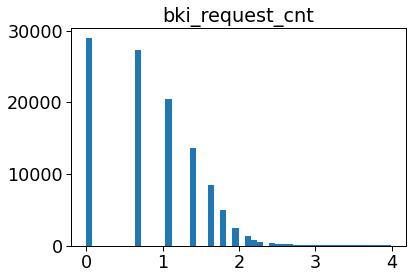

In [46]:
# прологарифмируем остальные числовые признаки
num_cols1 = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt']
for i in num_cols1:
    plt.figure()
    
    df[i] = df[i].apply(lambda w: np.log(w + 1))
    plt.hist(df[i], bins=50);
    plt.title(i)
    plt.show()
        

In [47]:
#Результат есть только для признака income


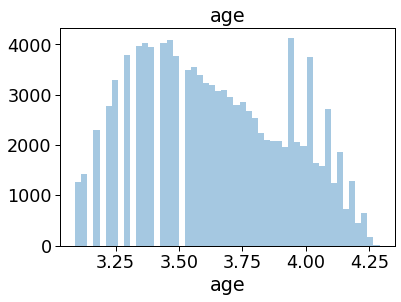

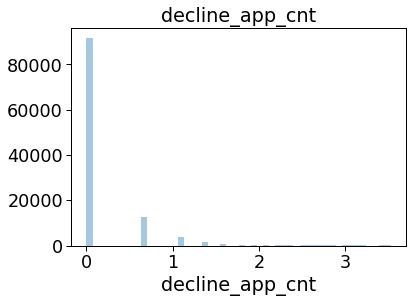

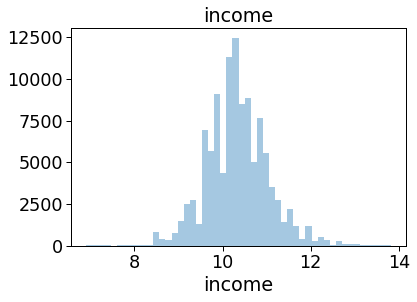

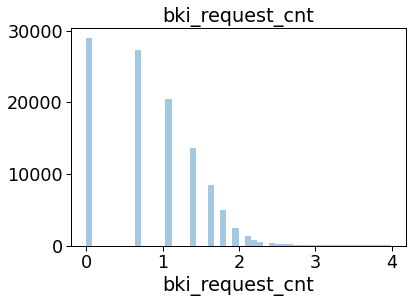

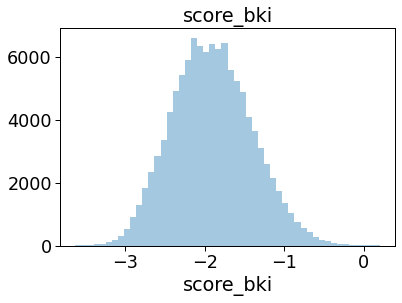

In [48]:
# Проверим что получилось

for i in num_cols:
    plt.figure()
    sns.distplot(df[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

<AxesSubplot:>

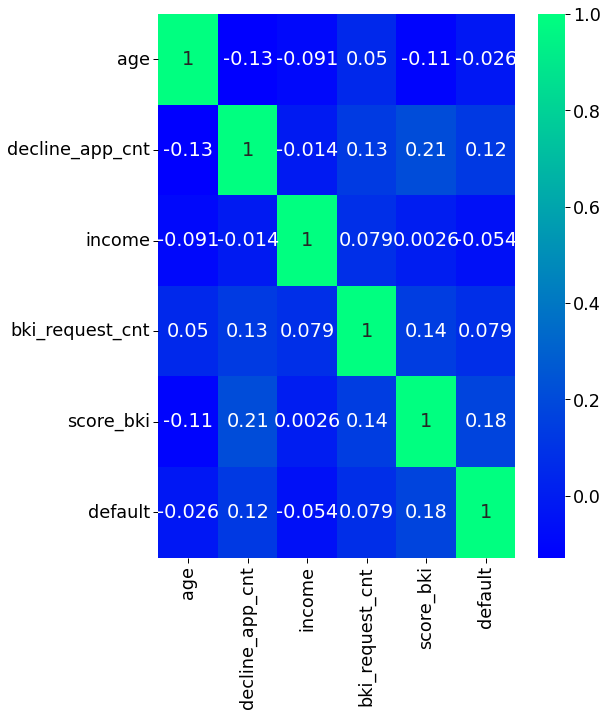

In [49]:
# Построим матрицу корреляций для числовых признаков
plt.figure(figsize=(8, 10))
sns.heatmap(df[num_cols+['default']].corr(), cmap='winter', annot=True)

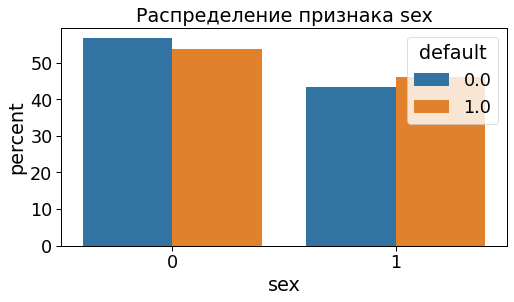

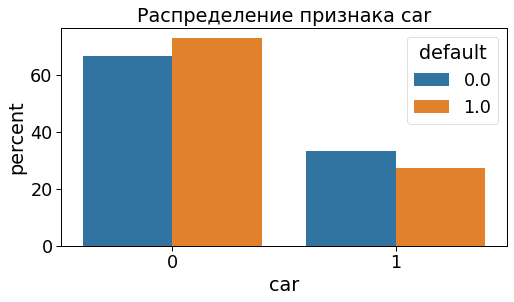

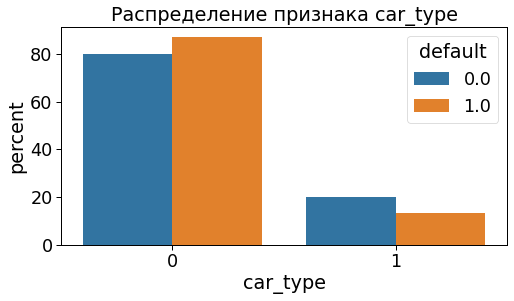

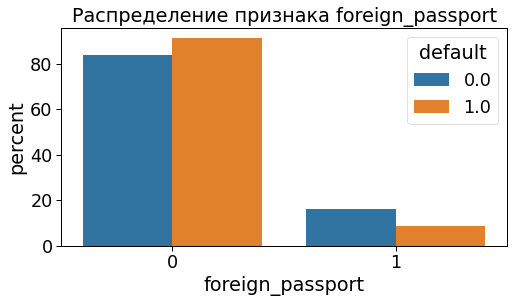

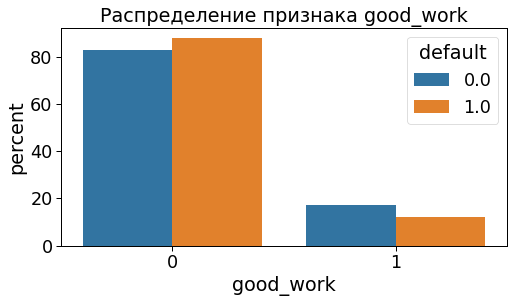

In [50]:
# Построим графики распределения бинарных переменных по целевой переменной
for col in bin_cols:
    plt.figure(figsize=(8, 4))
    prob_df = df[col].groupby(df['default']).value_counts(normalize=True).rename('percent').reset_index()
    prob_df['percent'] *= 100
    sns.barplot(x=col, y='percent', hue='default', data = prob_df)
    plt.title(f'Распределение признака {col}')
    
    

# 

<AxesSubplot:>

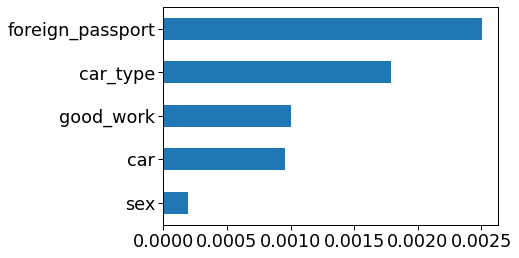

In [51]:
# Проверим значимость бинарных переменных
temp_df = df[df['train'] == 1]
imp_cat = Series(mutual_info_classif(temp_df[bin_cols], temp_df['default'], discrete_features=True), index=bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

<AxesSubplot:>

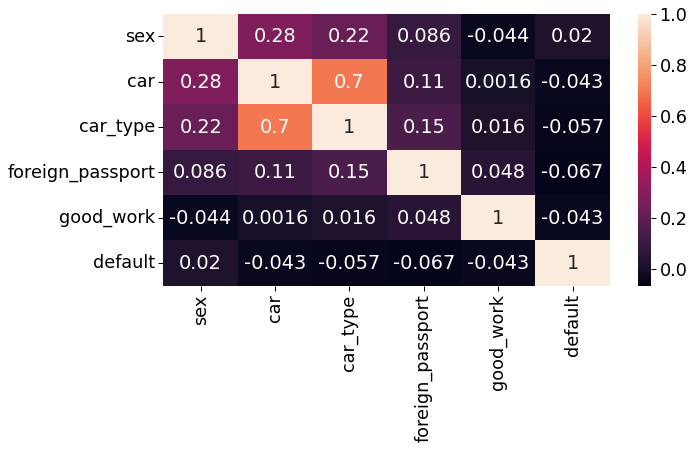

In [52]:
# Построим матрицу корреляций для бинарных переменных
plt.figure(figsize=(10,5))
sns.heatmap(df[bin_cols+['default']].corr(), annot=True)

Больше других коррелируют car и car_type оставим оба

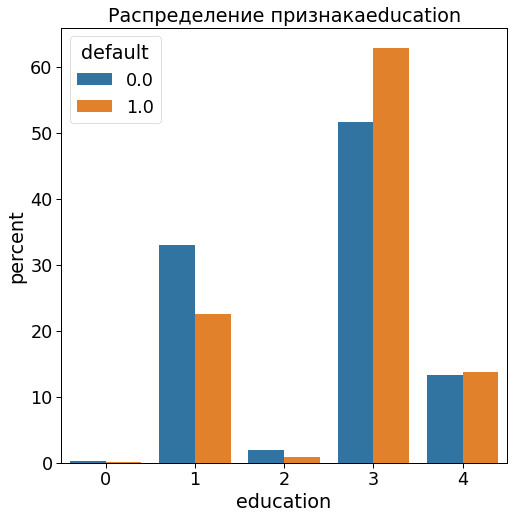

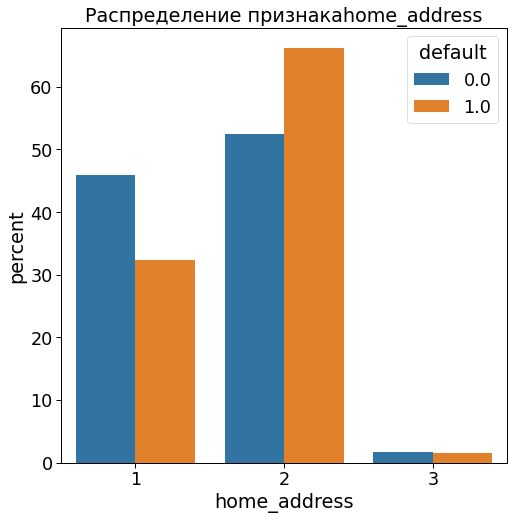

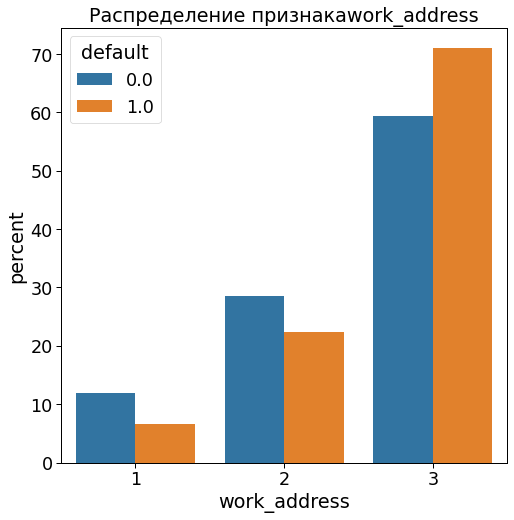

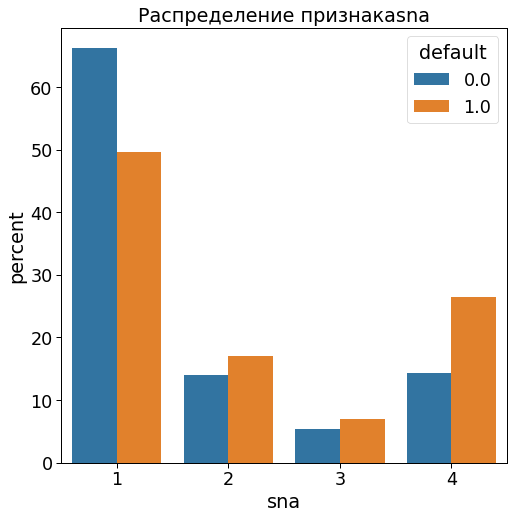

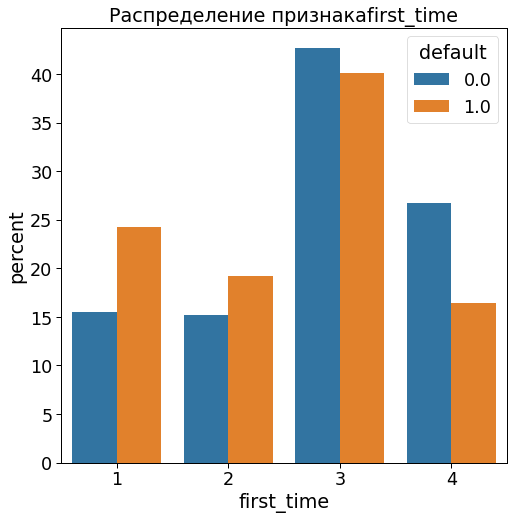

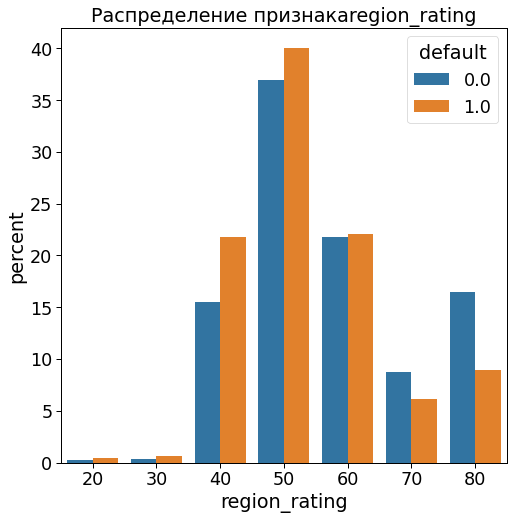

In [53]:
# Построим графики распределения значений по отношению к целевой переменной
for col in cat_cols:
    plt.figure(figsize=(8,8))
    prop_df = df[col].groupby(df['default']).value_counts(normalize=True).rename('percent').reset_index()
    prop_df['percent'] *= 100
    sns.barplot(x=col, y='percent', hue='default', data=prop_df)
    plt.title(f'Распределение признака{col}')

<AxesSubplot:>

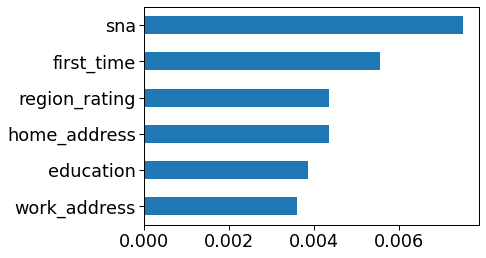

In [54]:
# Проверим значимость категориальных переменных
temp_df = df[df['train'] == 1]
imp_cat = Series(mutual_info_classif(temp_df[cat_cols], temp_df['default'], discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

<AxesSubplot:>

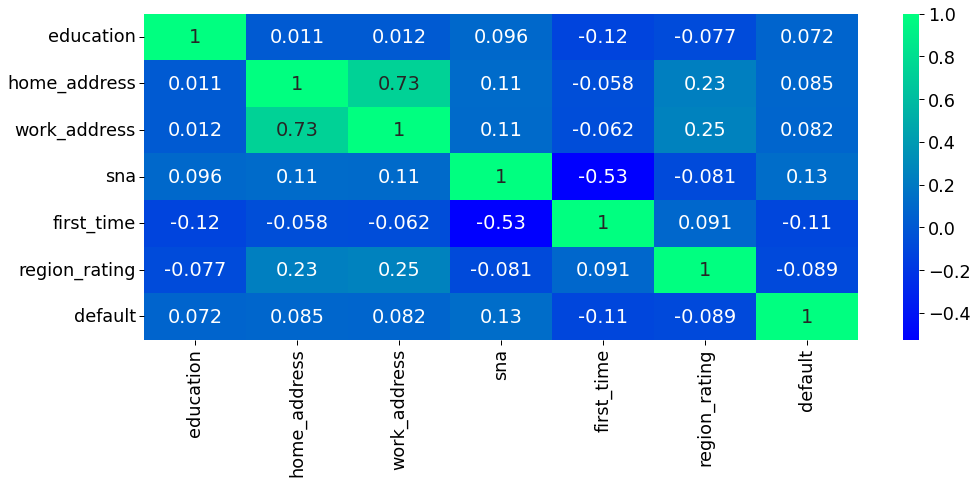

In [55]:
# Построим матрицу корреляций для категориальных переменных
plt.figure(figsize=(16,6))
sns.heatmap(df[cat_cols+['default']].corr(), cmap='winter', annot= True)

<AxesSubplot:>

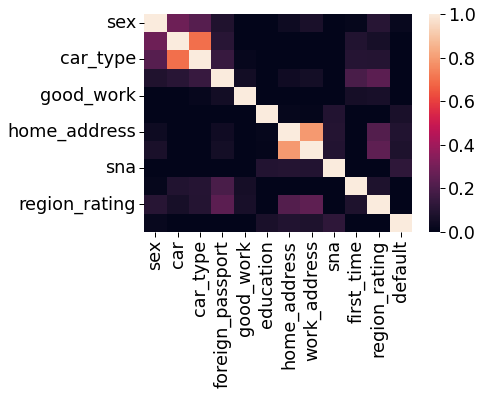

In [56]:
# Посмотрим как бинарные и категориальные признаки коррелируют между собой и с целевой переменной
sns.heatmap(df[bin_cols + cat_cols + ['default']].corr(method='spearman'), vmin=0, vmax=1)

Строим модель

In [57]:
#Делим датасет обратно на трейн и тест
train = df.query('train == 1').drop(['train'], axis=1)
test = df.query('train == 0').drop(['train'], axis=1)

In [58]:
#Делим категориальные переменные на 0 и 1
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)


In [59]:
X_cat.shape

(73799, 26)

In [60]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(train[num_cols].values)


Объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [61]:
#Объединяем

X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

In [62]:
#Подготовка для модели завершена. Разделим данные для обучения:

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42 )

Создадим и обучим первую модель на стандартных настройках логистической регрессии

In [64]:
model_1 = LogisticRegression(max_iter=1000, random_state=42)
model_1.fit(X_train, y_train)
preds = model_1.predict(X_test)

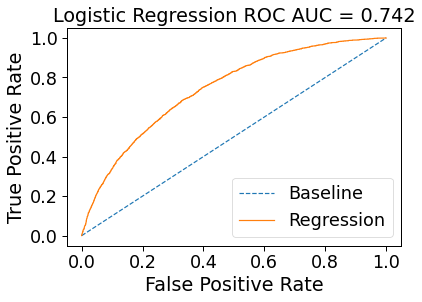

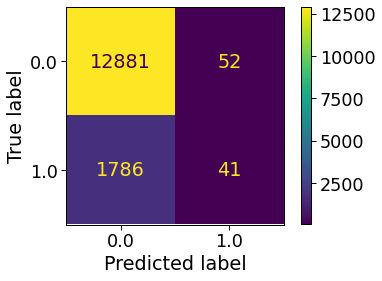

In [65]:
probs = model_1.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = "lower right")
plt.show()

plot_confusion_matrix(model_1, X_test, y_test)
plt.show()


In [66]:

print('Accuracy: %.3f' % accuracy_score(y_test, preds))
print('Precision: %.3f' % precision_score(y_test, preds))
print('Recall: %.3f' % recall_score(y_test, preds))
print('F1: %.3f' % f1_score(y_test, preds))
print('MSE: {}' .format(np.round(mean_squared_error(y_test, preds), 3)))


Accuracy: 0.875
Precision: 0.441
Recall: 0.022
F1: 0.043
MSE: 0.125


Найдем оптимальное значение параметра для логистической регрессиию Произведем поиск гиперпараметров GridSearchCV при помощи перебора параметров по сетке с последующей валидацией

In [67]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(solver = 'liblinear', max_iter = 100)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее С:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l1
Лучшее С: 1.0


# GridSearchCV - Настройка гиперпараметров поиском по сетке
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegression(random_state=42)

param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['none', 'balanced'],
    'multi_class': ['auto', 'ovr'],
    'max_iter': [100]},
    {'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight': ['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
    'max_iter': [100]},
    {'penalty': ['none'],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'class_weight': ['none', 'balanced'],
    'multi_class': ['auto', 'ovr'],
    'max_iter': [100]}
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
# печатаем метрики
best_parameters = model.get_params()


for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))
    # метрики
preds = model.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, preds))
print('Precision: %.3f' % precision_score(y_test, preds))
print('Recall: %.3f' % recall_score(y_test, preds))
print('F1: %.3f' % f1_score(y_test, preds))
print('MSE: {}' .format(np.round(mean_squared_error(y_test, preds), 3)))


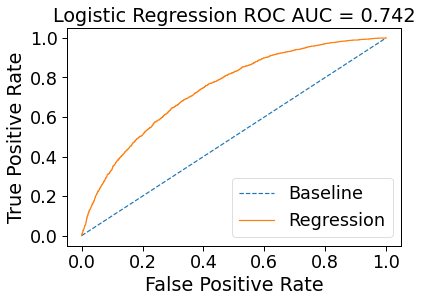

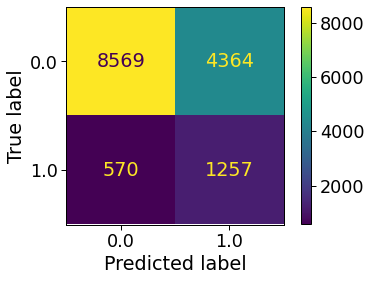

In [68]:
# Подбираем гиперпараметры вручную
model = LogisticRegression(max_iter=1000, C=100,
                          class_weight='balanced',
                          multi_class='auto',
                          penalty='l2',
                          random_state=42,
                          solver='liblinear',
                          tol=0.0001,
                          verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = "lower right")
plt.show()

plot_confusion_matrix(model, X_test, y_test)
plt.show()


Обрабатываем тестовую выборку, загружаем в модель и готовим submission

In [69]:
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)
X_num_test = StandardScaler().fit_transform(test[num_cols].values)

X_test_test = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])
y_probs = model.predict_proba(X_test_test)[:,1]

In [70]:
test['default'] = y_probs

In [71]:
submission = test[['client_id', 'default']]
display(submission.sample(10))
display(submission.shape)

,client_id,default
92868,106267,0.465410
80387,3000,0.082823
90901,61616,0.275323
77249,76080,0.834329
108120,60578,0.361107
102473,19254,0.586602
107804,47547,0.626712
85663,101335,0.329571
104282,23128,0.767255
86490,70402,0.500019


(36349, 2)

In [72]:
submission.to_csv('submission.csv', index=False)